## Employee Attrition Analysis and Prediction
###### Project Overview
- This project aims to analyze and predict employee attrition at Acme Corporation. High employee turnover is a significant concern for organizations, as it impacts team dynamics, project continuity, and overall morale. Through this analysis, we aim to understand the factors influencing employee attrition and develop a predictive model to identify employees at risk of leaving the company.

As an Expert Senior Data Scientist tasked with **Employee Attrition Analysis and Prediction**, my approach would be methodical, covering each aspect of the project from understanding the business problem to deploying a predictive model. Here’s the detailed step-by-step approach:

### Step 1: **Understand the Business Problem**
- **Objective**: The goal is to understand why employees are leaving (attrition) and build a predictive model to forecast which employees are likely to leave.
- **Impact**: High attrition can cost the company in recruitment, training, and team efficiency. Predicting it enables proactive measures to retain talent.
- **Stakeholders**: HR Team, Business Managers, and Executives who want actionable insights to reduce turnover.
  
**Action**: 
- Meet with stakeholders to clarify expectations, define key metrics (e.g., cost of attrition), and understand any domain-specific nuances.

### Step 2: **Data Acquisition and Exploration**
- **Dataset**: Begin by collecting and reviewing the dataset provided by HR, which contains employee demographics, job satisfaction, performance metrics, etc.
  
**Action**:
- **Load the dataset**: Import the CSV file and check its structure (columns, data types, etc.).
- **Initial Data Exploration**:
  - Get an overview of the dataset (e.g., `data.info()`, `data.describe()`).
  - Identify the target variable (Attrition) and the distribution of this variable (is the dataset imbalanced?).
  - Explore each column and its significance (e.g., MonthlyRate, YearsAtCompany).

### Step 3: **Data Cleaning and Preprocessing**
- **Missing Values**: Identify any missing or null values and determine the appropriate strategy (imputation, deletion).
- **Outliers**: Detect outliers using statistical methods or visualization techniques.
- **Categorical Variables**: Handle categorical variables (e.g., Department, BusinessTravel, etc.) using encoding techniques like One-Hot Encoding or Label Encoding.
- **Feature Scaling**: Scale numerical columns like MonthlyIncome, YearsAtCompany, etc., especially if models like SVM or KNN are being used.
- **Data Imbalance**: If the dataset is imbalanced (more employees stay than leave), consider techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset.

**Action**:
- Handle missing data (e.g., `data.fillna()`).
- Encode categorical data using `pd.get_dummies()` or `LabelEncoder`.

### Step 4: **Exploratory Data Analysis (EDA)**
- **Goal**: Identify patterns and trends in the dataset that affect employee attrition.
- **EDA Tools**: Use plots and statistical techniques to explore relationships.
  - **Correlation**: Check correlation between features and attrition using a heatmap.
  - **Distribution**: Analyze the distribution of key features like MonthlyIncome, JobSatisfaction, YearsAtCompany.
  - **Segment Analysis**: For example, visualize attrition by department, education, and job role using bar plots or pie charts.
  - **Interaction Effects**: Identify interaction effects (e.g., do employees with lower job satisfaction and higher overtime tend to leave more?).

**Action**:
- Create heatmaps, pair plots, and box plots to visualize relationships.
- Explore key metrics by segmenting the data based on different employee attributes.

### Step 5: **Feature Engineering**
- **Feature Selection**: Use techniques like Recursive Feature Elimination (RFE) or correlation analysis to select the most important features that influence attrition.
- **New Features**: Create new features that might add value (e.g., years since last promotion, income growth rate, work-life balance score, etc.).
- **Interaction Terms**: Consider adding interaction terms between variables (e.g., job role and satisfaction) if they significantly impact attrition.

**Action**:
- Engineer new features that might provide more insight into attrition risk.
  
### Step 6: **Model Selection**
- **Goal**: Build a model to predict employee attrition.
- **Binary Classification Models**:
  - **Logistic Regression**: Simple, interpretable baseline.
  - **Random Forest/Decision Trees**: Handle non-linearity and provide feature importance.
  - **Gradient Boosting Machines (GBM)**: Advanced algorithms like XGBoost, LightGBM, or CatBoost, which are more accurate and handle imbalanced datasets well.
  - **SVM/Neural Networks**: Consider if the dataset has complex patterns.
  
**Action**:
- Split the data into train and test sets (`train_test_split()`).
- Train multiple models and evaluate performance using metrics like accuracy, precision, recall, and F1-score.
  
### Step 7: **Model Evaluation and Tuning**
- **Model Evaluation**: Focus on metrics that matter for the business. For imbalanced data, precision, recall, and F1-score are more important than accuracy.
- **Cross-Validation**: Perform k-fold cross-validation to ensure the model generalizes well.
- **Hyperparameter Tuning**: Use Grid Search or Random Search to find the optimal parameters for models like Random Forest or XGBoost.
  
**Action**:
- Use `GridSearchCV` or `RandomizedSearchCV` for hyperparameter tuning.
- Evaluate using a confusion matrix, classification report, and ROC-AUC curve.

### Step 8: **Model Interpretation**
- **Feature Importance**: For tree-based models, extract feature importance to understand which factors contribute most to employee attrition (e.g., overtime, job satisfaction).
- **SHAP/ LIME**: For more complex models, use interpretability tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to explain predictions.
  
**Action**:
- Generate feature importance and SHAP plots to explain the model's decisions.

### Step 9: **Deploying the Model**
- **Model Deployment**: Prepare the model for deployment if needed (e.g., integrating with HR systems).
- **Monitoring**: Set up a monitoring framework to track model performance over time (e.g., regular retraining if the data changes).

**Action**:
- Prepare the model using tools like Flask or FastAPI if real-time predictions are needed.
- Ensure a retraining pipeline is in place.

### Step 10: **Presentation and Recommendations**
- **Key Insights**: Present the key insights from the analysis. For example, "Employees with low job satisfaction and higher overtime are more likely to leave."
- **Actionable Recommendations**: Based on the insights, suggest proactive measures such as increasing work-life balance initiatives or improving job satisfaction scores.
  
**Action**:
- Prepare visualizations (graphs, dashboards) for presenting results to stakeholders.

---

### Timeline for 7 Days:
- **Day 1-2**: Understand business problem, data exploration, and data cleaning.
- **Day 3**: Perform EDA and initial feature engineering.
- **Day 4-5**: Model selection, training, and tuning.
- **Day 6**: Model evaluation, interpretation, and documentation of insights.
- **Day 7**: Final report and presentation.

This step-by-step breakdown ensures that the project follows a systematic approach, leading to meaningful insights and a robust predictive model. Let me know if you'd like to start with any particular step!

In [8]:
#import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load the dataset
data = pd.read_csv("train.csv")

In [3]:
# See first and last few rows
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [4]:
# Overview of data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
# check for missing values
data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [6]:
# explore basic statistic
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


```
Dataset contains 1470 rows and 35 columns. No missing values detected.
```

In [7]:
# checks the distribution of the target variable
data["Attrition"].value_counts(normalize = True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

```
No (stayed): 83.88% of employees stayed with the company.
Yes (left): 16.12% of employees left the company.
# class imbalance,
```

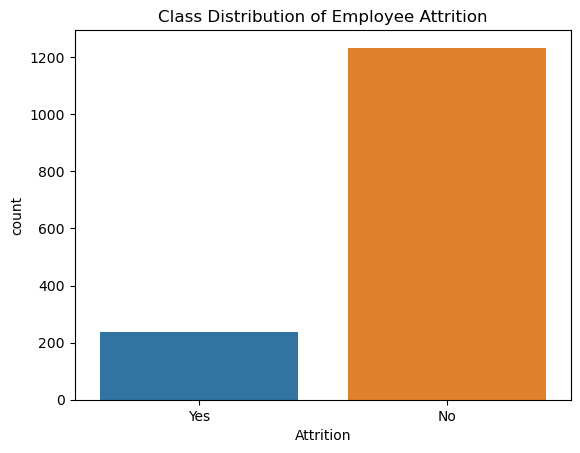

In [9]:
# Visualize the class distribution
sns.countplot(x = "Attrition", data = data)
plt.title('Class Distribution of Employee Attrition')
plt.show()